In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

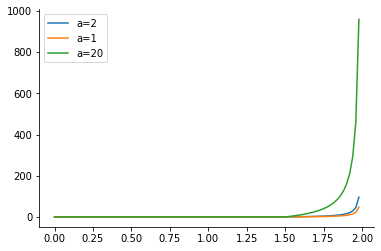

In [266]:
a = 2
func2 = (2/(2 - y_grid_cap[:-1] ) - 2/(2-1.5))*(y_grid_cap[:-1]>=1.5)
func1 = (1/(2 - y_grid_cap[:-1] ) - 1/(2-1.5))*(y_grid_cap[:-1]>=1.5)
func20 = (20/(2 - y_grid_cap[:-1] ) - 20/(2-1.5))*(y_grid_cap[:-1]>=1.5)
plt.plot(y_grid_cap[:-1],func2, label="a=2")
plt.plot(y_grid_cap[:-1],func1, label="a=1")
plt.plot(y_grid_cap[:-1],func20, label="a=20")
plt.legend()

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0, 1/3, 2)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
# γ3_list_test = γ3_list[[0,1,2,-1]]
# γ3_list = γ3_list_test

In [3]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [4]:
from multiprocessing import Pool
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [22]:
args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
solution_low = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

episode: 5000,	 ode error: 0.00037728350639623653,	 ft error: 0.00016525157220925735


In [8]:
args_list = []
for y_tilde in jump_interval:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 5000, 1e-7, 0.5)
        args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        
#         ϕ, ems, _, _ = solve_smooth_100()
#         ϕ_list.append(ϕ)
#         e_list.append(ems)
#     ϕ_list = np.array(ϕ_list)
#     e_list = np.array(e_list)
#     res_list.append((ϕ_list, e_list))

In [9]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 2433,	 ode error: 0.00025184937058989054,	 ft error: 9.978877801852803e-08
episode: 2679,	 ode error: 0.000549758824288045,	 ft error: 9.981084758692305e-08
episode: 2683,	 ode error: 0.000564088258230934,	 ft error: 9.960132274500211e-08
episode: 2501,	 ode error: 0.00023304680467108735,	 ft error: 9.994464678086956e-08
episode: 2675,	 ode error: 0.0005351792552360582,	 ft error: 9.992848681861233e-08
episode: 2602,	 ode error: 0.00032573422613314806,	 ft error: 9.991067084769156e-08
episode: 2543,	 ode error: 0.0002796782636365347,	 ft error: 9.981685167304022e-08
episode: 2550,	 ode error: 0.0002949205380490816,	 ft error: 9.982420223764166e-08
episode: 2657,	 ode error: 0.00047785931163019796,	 ft error: 9.963242852961685e-08
episode: 2651,	 ode error: 0.000456930580036978,	 ft error: 9.984824878017662e-08
episode: 2572,	 ode error: 0.00032501690017415485,	 ft error: 9.98656730644143e-08
episode: 2637,	 ode error: 0.00041004303785057566,	 ft error: 9.99529259360088e-08
epi

episode: 2725,	 ode error: 0.0007284060302342119,	 ft error: 9.99116416267043e-08
episode: 2709,	 ode error: 0.0006668320764106131,	 ft error: 9.984113269467798e-08
episode: 2724,	 ode error: 0.0007168010516223171,	 ft error: 9.96929667707036e-08
episode: 2438,	 ode error: 0.00025495877249750304,	 ft error: 9.960753211135653e-08
episode: 2735,	 ode error: 0.0007534415281890278,	 ft error: 9.96646711826088e-08
episode: 2700,	 ode error: 0.0006154311547792064,	 ft error: 9.9806246822709e-08
episode: 2645,	 ode error: 0.00043434139557343987,	 ft error: 9.956053226289896e-08
episode: 2644,	 ode error: 0.00043427693132339074,	 ft error: 9.993525829088412e-08
episode: 2703,	 ode error: 0.0006284356821142992,	 ft error: 9.95466749031948e-08
episode: 2727,	 ode error: 0.0007399585005781993,	 ft error: 9.959738989095968e-08
episode: 2675,	 ode error: 0.0005394895473012015,	 ft error: 9.972245429423765e-08
episode: 2721,	 ode error: 0.0006933834881893593,	 ft error: 9.963980751592771e-08
episode

episode: 2696,	 ode error: 0.0006483818828868573,	 ft error: 9.968609404609197e-08
episode: 2726,	 ode error: 0.0007458404935626294,	 ft error: 9.95366704614753e-08
episode: 2715,	 ode error: 0.0007276453482097482,	 ft error: 9.970652392610191e-08
episode: 2685,	 ode error: 0.0005885196989926789,	 ft error: 9.972964853943722e-08
episode: 2574,	 ode error: 0.0002948104456246825,	 ft error: 9.962045499634087e-08
episode: 2712,	 ode error: 0.0006986363830589343,	 ft error: 9.973685166642099e-08
episode: 2614,	 ode error: 0.0003543936655209731,	 ft error: 9.969097458650822e-08
episode: 2710,	 ode error: 0.0006858966712728724,	 ft error: 9.981144266646425e-08
episode: 2670,	 ode error: 0.0005374919607056931,	 ft error: 9.98208271596468e-08
episode: 2656,	 ode error: 0.00047902055993743337,	 ft error: 9.98602089907763e-08
episode: 2625,	 ode error: 0.0003818534607506127,	 ft error: 9.957199775811887e-08
episode: 2727,	 ode error: 0.0007575517980378289,	 ft error: 9.968260883397306e-08
episod

episode: 2641,	 ode error: 0.00043236744476652517,	 ft error: 9.981859960817019e-08
episode: 2539,	 ode error: 0.0002893619683579443,	 ft error: 9.977087112034155e-08
episode: 2705,	 ode error: 0.0007106849596671266,	 ft error: 9.953129342932243e-08
episode: 2684,	 ode error: 0.0006095453742827051,	 ft error: 9.982032800337493e-08
episode: 2654,	 ode error: 0.0004784871454712944,	 ft error: 9.974831627346248e-08
episode: 2582,	 ode error: 0.00029378670037442933,	 ft error: 9.978773540808561e-08
episode: 2718,	 ode error: 0.0007571219449925524,	 ft error: 9.95400881720343e-08
episode: 2648,	 ode error: 0.000456065477542969,	 ft error: 9.97911886457814e-08
episode: 2701,	 ode error: 0.0006730638300524831,	 ft error: 9.965766878394788e-08
episode: 2633,	 ode error: 0.0004077564909082468,	 ft error: 9.99917215693813e-08
episode: 2634,	 ode error: 0.0004079681026109838,	 ft error: 9.964889358116125e-08
episode: 2716,	 ode error: 0.0007404031850147472,	 ft error: 9.999806671601164e-08
episod

episode: 2677,	 ode error: 0.0005771887088795238,	 ft error: 9.997864403032963e-08episode: 2709,	 ode error: 0.0007349787053365399,	 ft error: 9.957408053651307e-08

episode: 2669,	 ode error: 0.0005410314194360354,	 ft error: 9.968821323980137e-08
episode: 2690,	 ode error: 0.0006419025815616944,	 ft error: 9.979404858029284e-08
episode: 2716,	 ode error: 0.0007694018322892231,	 ft error: 9.999410366390293e-08
episode: 2696,	 ode error: 0.000674849864607769,	 ft error: 9.967349257067326e-08
episode: 2709,	 ode error: 0.0007385634481156741,	 ft error: 9.955590485333232e-08
episode: 2713,	 ode error: 0.0007700483429305752,	 ft error: 9.971115488838223e-08
episode: 2621,	 ode error: 0.000379097943732698,	 ft error: 9.967852321324244e-08
episode: 5000,	 ode error: 0.00027793091242987733,	 ft error: 1.3837839493824333e-05
episode: 2723,	 ode error: 0.0008088722085109745,	 ft error: 9.980419690691633e-08
episode: 2673,	 ode error: 0.0005604775255176227,	 ft error: 9.978696624557415e-08
epis

episode: 2664,	 ode error: 0.0005203803070826102,	 ft error: 9.969881098470523e-08
episode: 2710,	 ode error: 0.0006391631057168744,	 ft error: 9.960394287134022e-08
episode: 2659,	 ode error: 0.0004997202458997228,	 ft error: 9.97866393959157e-08
episode: 2581,	 ode error: 0.0002931829703337191,	 ft error: 9.97804630031851e-08
episode: 2709,	 ode error: 0.0007454661027057503,	 ft error: 9.971391357055381e-08
episode: 2668,	 ode error: 0.0005487066692001358,	 ft error: 9.977706127983765e-08
episode: 2607,	 ode error: 0.0005486052968529352,	 ft error: 9.978240456121057e-08
episode: 2687,	 ode error: 0.0006283877428573358,	 ft error: 9.986528226590963e-08
episode: 2723,	 ode error: 0.0008273248416034475,	 ft error: 9.951857116163865e-08
episode: 2724,	 ode error: 0.0008408901877877198,	 ft error: 9.990907123835768e-08
episode: 2721,	 ode error: 0.0008092867187139002,	 ft error: 9.97382496592536e-08
episode: 2726,	 ode error: 0.0008456356907764716,	 ft error: 9.96455327140211e-08
episode:

'01h24m39s'

In [214]:
res_dict = pickle.load(open('../data/damage_prep_40_tight.p', 'rb'))

ϕ_ref = res_dict['φ_ref']
ems_ref = res_dict['ems_ref']
res_list = res_dict['res_list']

In [215]:
y_grid[len(prepre_jump)]

1.5

In [19]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [470]:
ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

count = 0
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
    ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
    for j in range(len(γ3_list[1:])):
        ϕ_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
        ems_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [23]:
ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_list[i, 0] = solution_low['φ']
    ems_list[i, 0] = solution_low['ems']
    for j in range(len(γ3_list[1:])):
        ϕ_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['φ']
        ems_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['ems']

In [472]:
res_dict = dict(res_list=res_list, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
pickle.dump(res_dict, open("../data/damage_prep_40_tight.p", "wb"))

In [24]:
len(res_list)/39

26.0

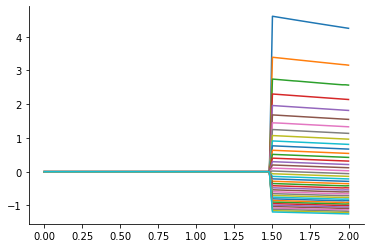

In [216]:
plt.plot(y_grid_cap,ϕ_ref.T)
plt.show()

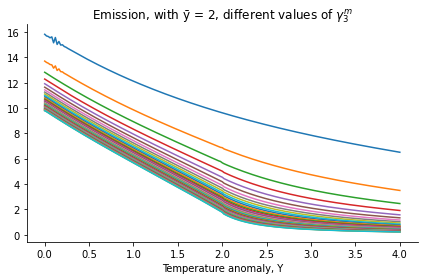

In [217]:
for i in range(len(dmg_weight)):
    plt.plot(y_grid,ems_list[-1, i, :])
plt.xlabel('Temperature anomaly, Y')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

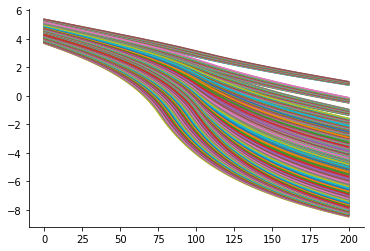

In [218]:
for i in range(len(res_list)):
    plt.plot(res_list[i]['φ'])

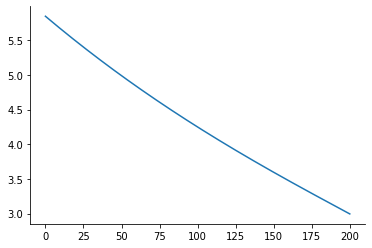

In [219]:
plt.plot(solution_low['φ'])

In [220]:
ϕ_ref.shape

(40, 101)

In [16]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

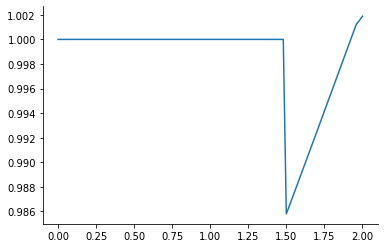

In [28]:
plt.plot(y_grid_cap, weighted)

In [29]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.4

In [30]:
r0, r1

(-0.4, -19.5000916299522)

In [31]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [32]:
ϕ_low = solution_low['φ']
ϕ_list_no_low = np.zeros((len(γ3_list[1:]), len(ϕ_low)))
for i in range(len(γ3_list[1:])):
    ϕ_list_no_low[i] = res_list[-(len(γ3_list[1:]) - i)]['φ']

In [33]:
ϕ_list_no_low.shape

(39, 201)

In [34]:
ϕ_list2 = np.concatenate(([ϕ_low], ϕ_list_no_low), axis=0)

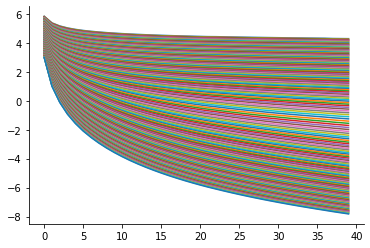

In [35]:
plt.plot(ϕ_list2)
plt.show()

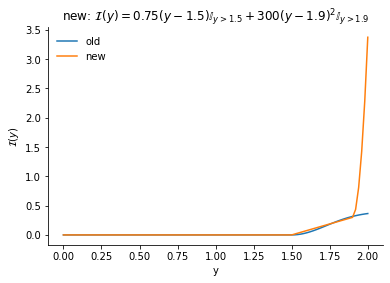

In [221]:
# plt.plot(y_grid_cap,3*intensity, label="x3")
# plt.plot(y_grid_cap,10*intensity, label="x10")
y_lower=1.5
intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
plt.plot(y_grid_cap, intensity, label="old")
y_lower=1.5
I = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)

# plt.plot(y_grid_cap, I, label="1.5")
y_lower=1.4
IO = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, IO, label="1.4")

func = 3/(y_bar - y_lower)**2*(y_grid_cap - y_lower)**2*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, func, label="test 1.4")

func1 = 3/(y_bar - 1.5)**2*(y_grid_cap -1.5)**2*(y_grid_cap >= 1.5)
# plt.plot(y_grid_cap, func1, label="test 1.5")

func2 = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)
plt.plot(y_grid_cap, func2, label="new")

plt.title(r"new: $\mathcal{I}(y) = 0.75(y - 1.5)\mathbb{I}_{y>1.5} + 300(y - 1.9)^2\mathbb{I}_{y > 1.9}$")
plt.xlabel('y')
plt.ylabel(r"$\mathcal{I}(y)$")
plt.legend(frameon=False)
# plt.savefig('intensity.png',dpi=500, facecolor="w", edgecolor="w")

In [268]:
ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list2), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)
ϕ_bound.shape

(201,)

In [286]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref - ϕ)))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.005266164739038355,	 ft error: 0.14492728690705922
episode: 2,	 ode error: 0.023478311673528422,	 ft error: 0.022198289388448228
episode: 3,	 ode error: 0.020000168408253104,	 ft error: 0.018682402773911894
episode: 4,	 ode error: 0.016935448356626644,	 ft error: 0.01567775813602998
episode: 5,	 ode error: 0.014095883437029394,	 ft error: 0.013022499108326785
episode: 6,	 ode error: 0.011520681150154581,	 ft error: 0.011476416770541065
episode: 7,	 ode error: 0.010073831792659003,	 ft error: 0.010716448957770686
episode: 8,	 ode error: 0.009062717954115947,	 ft error: 0.009877998735798976
episode: 9,	 ode error: 0.008664453318619775,	 ft error: 0.008951960047985874
episode: 10,	 ode error: 0.008134422974518468,	 ft error: 0.00847296670917319
episode: 11,	 ode error: 0.007517611231801377,	 ft error: 0.00808172849843447
episode: 12,	 ode error: 0.0070368229050225585,	 ft error: 0.0075989138160584835
episode: 13,	 ode error: 0.0067698554986007665,	 ft error: 0.00

episode: 121,	 ode error: 0.0010093942026154698,	 ft error: 0.0009969353715395535
episode: 122,	 ode error: 0.001008927227037923,	 ft error: 0.0009843555997179898
episode: 123,	 ode error: 0.0010084489977820119,	 ft error: 0.0009719427148620063
episode: 124,	 ode error: 0.0010079594769563834,	 ft error: 0.0009600696931011399
episode: 125,	 ode error: 0.0010074587226081046,	 ft error: 0.0009481872391092772
episode: 126,	 ode error: 0.0010069468904521824,	 ft error: 0.0009363249298131038
episode: 127,	 ode error: 0.0010064242334812193,	 ft error: 0.0009246198658958704
episode: 128,	 ode error: 0.001005891098466185,	 ft error: 0.0009133927164621802
episode: 129,	 ode error: 0.0010053479277718456,	 ft error: 0.0009021950779426469
episode: 130,	 ode error: 0.0010047952550286537,	 ft error: 0.0008910482865980285
episode: 131,	 ode error: 0.0010042337018978595,	 ft error: 0.0008799708435227593
episode: 132,	 ode error: 0.0010036639731021216,	 ft error: 0.000869252910844498
episode: 133,	 ode 

episode: 241,	 ode error: 0.001004025265641851,	 ft error: 1.4950326256091273e-05
episode: 242,	 ode error: 0.0010041002697097033,	 ft error: 1.3761587991822921e-05
episode: 243,	 ode error: 0.0010041704956337376,	 ft error: 1.2658644607199676e-05
episode: 244,	 ode error: 0.0010042361864903739,	 ft error: 1.1636129744196921e-05
episode: 245,	 ode error: 0.001004297579393982,	 ft error: 1.068893311195751e-05
episode: 246,	 ode error: 0.001004354906010859,	 ft error: 9.812196189784572e-06
episode: 247,	 ode error: 0.0010044083915537495,	 ft error: 9.001307095246602e-06
episode: 248,	 ode error: 0.0010044582504433568,	 ft error: 8.251894674238258e-06
episode: 249,	 ode error: 0.0010045046908857581,	 ft error: 7.559822027936036e-06
episode: 250,	 ode error: 0.0010045479106878252,	 ft error: 6.921179472207939e-06
episode: 251,	 ode error: 0.0010045881006934161,	 ft error: 6.3322771337581685e-06
episode: 252,	 ode error: 0.0010046254436999157,	 ft error: 5.789637174125062e-06
episode: 253,	

episode: 361,	 ode error: 0.0010050633262090637,	 ft error: 5.669818081699418e-08
episode: 362,	 ode error: 0.0010050632076315097,	 ft error: 5.5999774151160864e-08
episode: 363,	 ode error: 0.001005063090838438,	 ft error: 5.531666458225004e-08
episode: 364,	 ode error: 0.0010050629790451099,	 ft error: 5.464929930809603e-08
episode: 365,	 ode error: 0.001005062871018477,	 ft error: 5.3987263992638646e-08
episode: 366,	 ode error: 0.0010050627661580998,	 ft error: 5.3331076443896563e-08
episode: 367,	 ode error: 0.0010050626670595822,	 ft error: 5.2681211837324327e-08
episode: 368,	 ode error: 0.001005062568827271,	 ft error: 5.203806274778344e-08
episode: 369,	 ode error: 0.0010050624712475038,	 ft error: 5.14041760268924e-08
episode: 370,	 ode error: 0.001005062376130874,	 ft error: 5.078690845650158e-08
episode: 371,	 ode error: 0.0010050622842022634,	 ft error: 5.0175858135048657e-08
episode: 372,	 ode error: 0.0010050621959923553,	 ft error: 4.9571295956951644e-08
episode: 373,	 

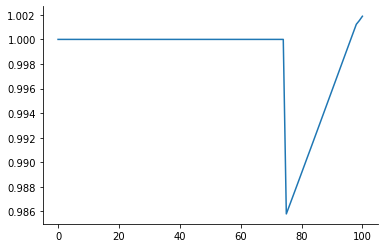

In [287]:
weighted, ϕ_new, g_list[:,-1]
plt.plot(weighted)

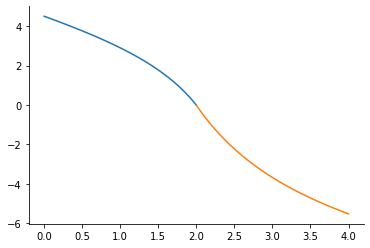

In [288]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
# plt.plot(ϕ_ref.T)
plt.show()

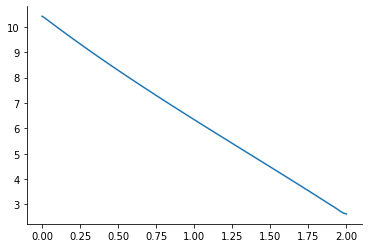

In [289]:
plt.plot(y_grid_cap,ems)
# plt.plot(y_grid_cap, ems_ref.T)
plt.show()

In [290]:
g_list[:,-1]

array([0.42676629, 0.53095817, 0.59745248, 0.65066559, 0.69421651,
       0.73202938, 0.76484396, 0.79519667, 0.82303195, 0.84881425,
       0.8728843 , 0.89550025, 0.91686277, 0.93713127, 0.9564347 ,
       0.974879  , 0.99255241, 1.00952937, 1.02587329, 1.0416388 ,
       1.05687327, 1.07161821, 1.08437136, 1.09818933, 1.11162031,
       1.12469005, 1.13742168, 1.14983604, 1.16195199, 1.17378665,
       1.18535564, 1.19667322, 1.20775247, 1.21860543, 1.22924316,
       1.23967591, 1.24991317, 1.26191725, 1.27179719, 1.28150496])

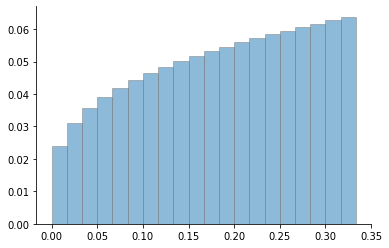

In [291]:
plt.hist(γ3_list, weights=g_list[:,-1]/np.sum(g_list[:,-1]), bins=20, ec="gray", alpha=0.5)
plt.show()

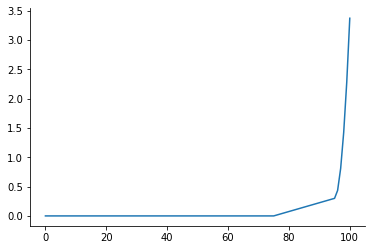

In [292]:
plt.plot(intensity)

In [328]:
def no_jump_simulation(dt):
    y = 1.1
    T = 120
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [347]:
def no_jump_simulation_long(ems, dt):
    y = 1.1
    T = 100
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [348]:
et, yt, probt = no_jump_simulation(dt=1/4)

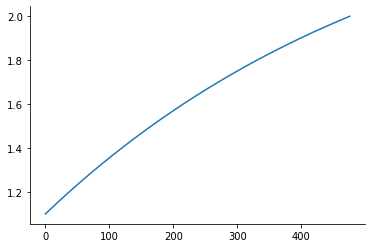

In [349]:
plt.plot(yt)

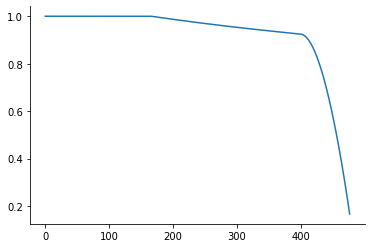

In [350]:
# year = np.arange(0, T-τ, τ)
plt.plot(probt)
# plt.ylim(0)

In [351]:
len(ems_list), jump_interval[-1]

(26, 2.0000000000000004)

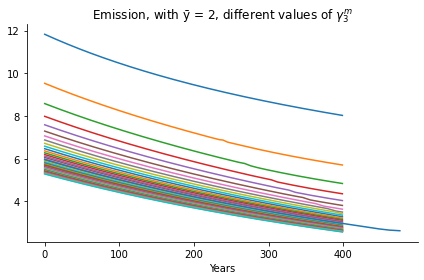

In [352]:
et_tests = []
for i in range(len(dmg_weight)):
    et_test, _, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
    plt.plot(et_test)
    et_tests.append(et_test)
    
plt.plot(et)    
plt.xlabel('Years')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.xlim(0,3)
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

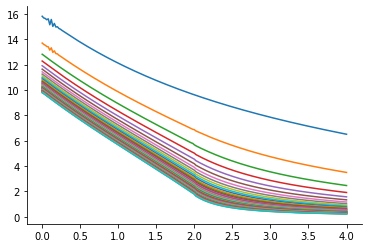

In [354]:
plt.plot(y_grid,ems_list[-1].T)
plt.show()

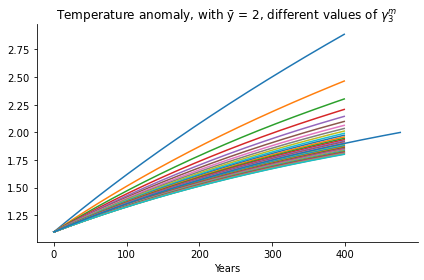

In [356]:
yt_refs = []
for i in range(len(dmg_weight)):
    _, yt_ref, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
    plt.plot(yt_ref, label="$\gamma2$")
    yt_refs.append(yt_ref)

# plt.legend()    
plt.plot(yt)
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
plt.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

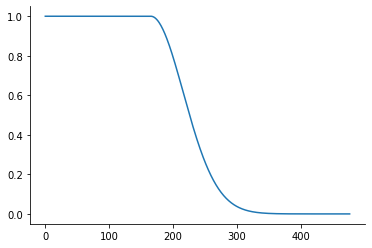

In [357]:
jump_prob = 1 - probt
integral = np.cumsum(jump_prob)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [358]:
prob_no_jump = np.cumprod(probt)
prob_no_jump, yt.shape

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.000000

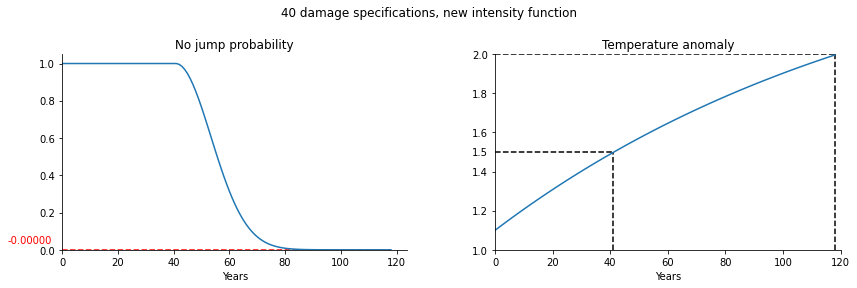

In [341]:
import matplotlib.transforms as transforms

T_jump = np.abs(yt-1.5).argmin()
T_stop = len(yt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('{} damage specifications, new intensity function'.format(len(dmg_weight)), y=0.99)
ax1.plot(prob_no_jump)
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")


ax2.plot(yt)
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop-1, color="black", linestyle="dashed")
ax2.vlines(T_stop-1, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, len(yt)+1) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax1.text(0,1.5, 1.5, color="black", transform=trans, 
        ha="right", va="center")

fig.tight_layout()

# fig.savefig('prob_anomaly_new.png',dpi=500, facecolor="w", edgecolor="w")

In [359]:
T_jump

41

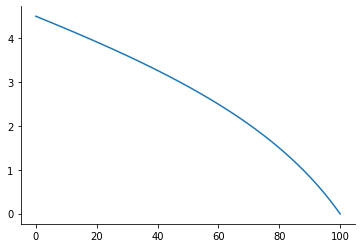

In [306]:
ϕ_list.shape
plt.plot(ϕ)

In [307]:
def jump_simulation():
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
    ems_list = res_dict['ems_list']
    ϕ_list = res_dict['φ_list']
    y0 = 1.1
    y_lower = 1.5
    T = 100
    dt = 1
    T = int(T/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            prob_i = intensity*(intensity<1) + (intensity>=1)
            et[t] = e_i
            probt[t] = 1-prob_i
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    T_extra = T - T_final
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        e_i = np.interp(y, y_grid_cap, ems)
#         prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)

        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        PROB[:, t] = prob_no[t]
        EMS[:, t] = et[t]
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        if t == T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt


            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                PROB[dmg+1, t] = intensity*dmg_weight[dmg]
                GS[dmg + 1, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[dmg+1,t]
                EMS[dmg+1, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[dmg+1, t] =  yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            intensity = intensity*(intensity<1) + (intensity>=1)
            
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dmg_weight[dmg]
                GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg,loc+len(prepre_jump)]))*PROB[id_dmg, t]
                EMS[id_dmg, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = yt[t]
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
        
        for t in range(T_final, T+1):
            EMS[0, t] = EMS[0,t-1]
            probt[t] = 0
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = et[t-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
            for time in range(T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    GS[id_dmg, t] = np.exp(1/ξp*(ϕ[loc+len(prepre_jump)] - ϕ_list[loc, dmg, loc+len(prepre_jump)]))*PROB[id_dmg, t]
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, PROB, GS, YS, EMS

In [308]:
solu = jump_simulation()

42


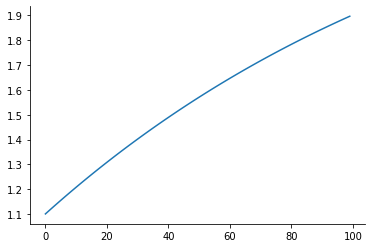

In [309]:
plt.plot(solu[1])

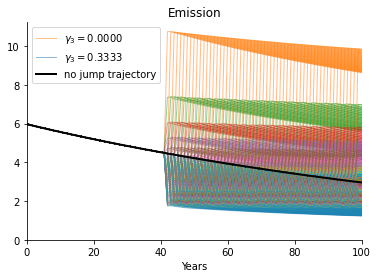

In [310]:
solu[-2][1], 
ems_test = solu[-1]

color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(ems_test[i, :len(yt)-1], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(solu[0])
plt.plot(et[:-1], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
solu[-3][:,-1].sum()
# plt.plot(solu[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, len(solu[0]))
plt.legend()
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

(1.1, 3.2)

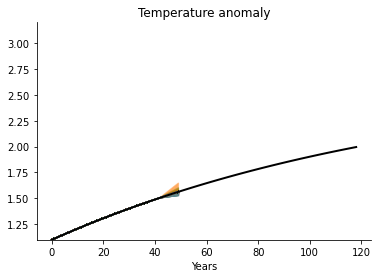

In [311]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :50], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

(1.1, 3.2)

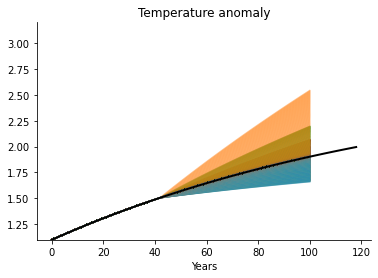

In [312]:
# 120
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :120], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [313]:
np.interp(3, y_grid_cap, ems_ref[0])

9.625855283479735

(0.0, 1.05)

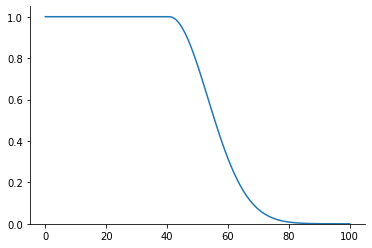

In [315]:
plt.plot(solu[3][:len(yt)])
plt.ylim(0)

In [316]:
solu[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.95529315e-01, 9.84885087e-01,
       9.68269860e-01, 9.45994283e-01, 9.18467478e-01, 8.86184524e-01,
       8.49711722e-01, 8.09670101e-01, 7.66717954e-01, 7.21533031e-01,
       6.74795044e-01, 6.27169152e-01, 5.79290896e-01, 5.31753082e-01,
      

In [319]:
solu[3], solu[-2][1], solu[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = solu[-4][:,100]

prob_test.sum()

0.9999715834206131

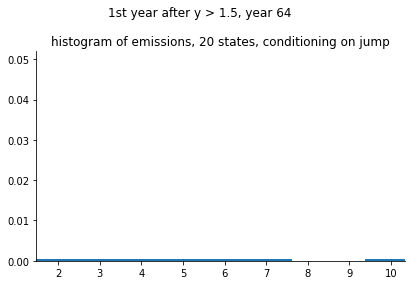

In [320]:
ems1 = solu[-1][:,65]
ems1 = ems1[np.nonzero(ems1)]
y1 = solu[-3][:,65]
y1 = y1[np.nonzero(y1)]
prob1 = solu[-2][:, 65]
prob1 = prob1[np.nonzero(prob1)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("1st year after y > 1.5, year 64")
axes.bar(ems1[1:], height=prob1[1:]/np.sum(prob1[1:]))
axes.set_xlim(np.min(ems1), np.max(ems1))
# axes[1].bar(y1[1:], height=prob1[1:]/np.sum(prob1[1:]))


axes.set_title("histogram of emissions, 20 states, conditioning on jump")
# axes[1].set_title("histogram of temperature anomaly, 20 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
axes.set_xlim(np.min(ems1), np.max(ems1))
# plt.savefig("histogram_1.png", facecolor="w", edgecolor="w")
plt.show()

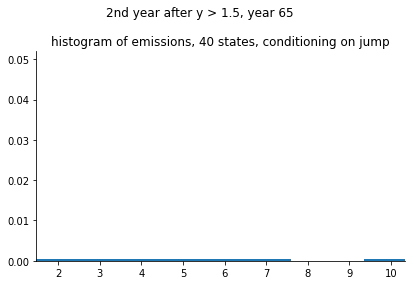

In [321]:
ems2 = solu[-1][:,66]
ems2 = ems2[np.nonzero(ems2)]
y2 = solu[-3][:, 66]
y2 = y2[np.nonzero(y2)]
prob2 = solu[-2][:, 66]
prob2 = prob2[np.nonzero(prob2)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("2nd year after y > 1.5, year 65")
axes.bar(ems2[1:], height=prob2[1:]/np.sum(prob2[1:]))
# axes[0].set_xlim(np.)
# axes.bar(y2[1:], prob2[1:]/np.sum(prob2[1:]) )
axes.set_xlim(np.min(ems1), np.max(ems1))
axes.set_title("histogram of emissions, 40 states, conditioning on jump")
# axes.set_title("histogram of temperature anomaly, 41 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
# axes[1].set_xlim(1.5, 1.8)
# plt.savefig("histogram_2.png", facecolor="w", edgecolor="w")
plt.show()

In [322]:
len(yt)

119

In [323]:
t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

IndexError: index 118 is out of bounds for axis 1 with size 101

In [324]:
y_110[0], yt[-1], prob_110.sum()

(2.267492172601886, 1.9958987967547193, 1.0)

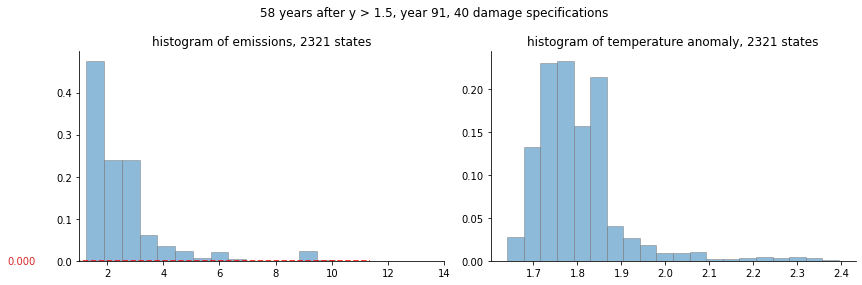

In [325]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
t = 91
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)),t, len(dmg_weight)))
axes[0].hist(ems_110, weights=prob_110, 
             bins=np.linspace(0, 12, 20), 
             alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=20,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

p = axes[0].patches

distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.1,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")
# no jump
# axes[0].hlines(distribution[np.nonzero(distribution)][-2], 0, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# axes[0].text(-0.1,distribution[np.nonzero(distribution)][-2], "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="right", va="center")
axes[0].set_xlim(1,14)
# axes[1].set_xlim(1.6, 3.2)
# axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("histogram_new.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

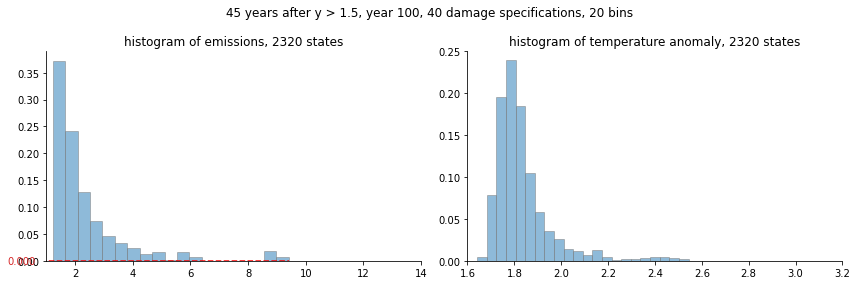

In [326]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-55, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

IndexError: index 118 is out of bounds for axis 1 with size 101

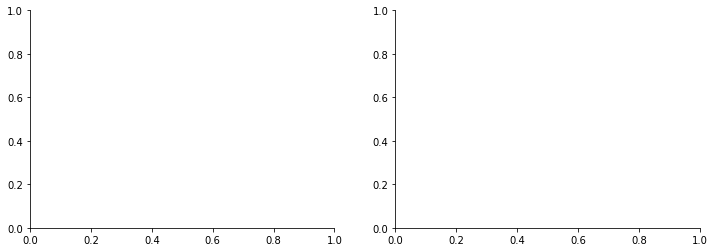

In [327]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(ems_test[i, :len(yt)], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(solu[0])
ax1.plot(et, color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(solu[0]))
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, bins=20,
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
        ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,14)
ax1.set_ylim(0,14)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 46".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
# plt.savefig("../figures/20_damages/emission_hist_new.png",facecolor="w", edgecolor="w", dpi=500)

In [212]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

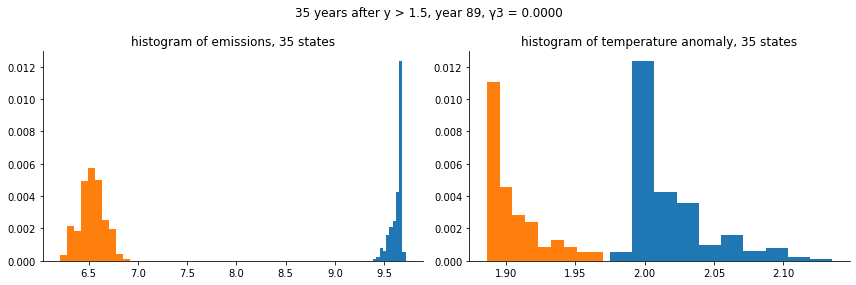

In [213]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
np.abs(distribution).argmax()

In [ ]:
bins[2], bins[3]

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')